# Titanic Tinkering

Този notebook служи като допълнение на този, представен на [лекцията](http://fmi.machine-learning.bg/lectures/06-titanic).
Не виждам смисъл да повтарям data exploration-а и директно ще премина към feature engineering.

Ще пробвам да постигна по-добър резултат на Leaderboard-a, като променя малко feature-ите и оптимизирам хипер-параметрите на RandomForestClassifier модела. 

In [734]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

In [735]:
train_data = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')
test_data = pd.read_csv('data/titanic/test.csv', index_col='PassengerId')

### Title

Титлите ще ги оставя както бяха показани на лекцията, защото с тях ми дава най-добър резултат. Пробвах и вариант, в който Rare титлите ги разделих на 3 подразделения (military, honorific и other), но това не помогна.

In [705]:
def process_title(data):
    data['Title'] = data['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
    
    data.loc[data.Title == 'Mlle', 'Title'] = 'Miss'
    data.loc[data.Title == 'Mme', 'Title']  = 'Mrs'
    data.loc[data.Title == 'Ms', 'Title']   = 'Miss'
    
    rare = ['Jonkheer', 'Don', 'Dona', 'Lady', 'the Countess', 'Sir', 'Col', 'Major', 'Capt', 'Rev', 'Dr']
    data.Title.replace(rare, 'Rare', inplace=True)

### Deck

Забелязах, че всеки от билетите започва с буква. Оказа се, че тази буква показва палубата.

In [748]:
def print_decks(df):
    cabins = df.Cabin.fillna('U')
    print(cabins.map(lambda c: c[0]).value_counts())

print("Deck values for train data:")
print_decks(train_data)

print()
print("Deck values for test data:")
print_decks(test_data)


Deck values for train data:
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

Deck values for test data:
U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64


Повечето от билетите липсват, затова при тях слагам стойност 'U' от 'Unknown'.

Също така виждаме, че в трейн сета има някаква палуба Т. Според Уикипедия такава палуба няма, следователно е някаква грешка. Причислявам го към 'Unknown'.

In [749]:
def process_cabin(data):
    data.Cabin.replace('T', 'U', inplace=True)
    data.Cabin.fillna('U', inplace=True)
    data['Deck'] = data.Cabin.map(lambda c: c[0])

### Family Size

На лекцията видяхе, че е по-вероятно да оцелееш, ако не пътуваш сам.

Ще създадем нови feature-и, свързани с големината на семейството. Използвам 'FamilySize' само за да си направя другите 3 feature-а, след това ще го затрия (заедно с 'Parch' и 'SibSp'). 

In [708]:
def process_family_size(data):
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
    
    data['IsAlone'] = (data.FamilySize == 1).astype(float)
    data['IsSmallFamily'] = ((2 <= data.FamilySize) & (data.FamilySize <= 4)).astype(float)
    data['IsLargeFamily'] = (5 <= data.FamilySize).astype(float)

### Age

Липсващите години ще ги попълним със средно аритметичните за титлата им.

Реших да bin-на годините на групи, защото получавах лоши резултати като бяха непрекъснат feature. Разделих ги на 5 групи, които обхващат не лошо всички възрастови групи.

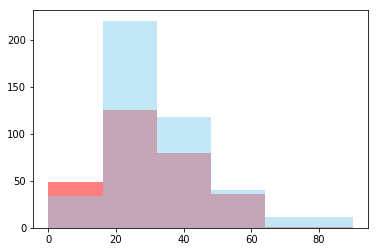

In [764]:
bins=[0, 16, 32, 48, 64, 90]

plt.hist(list(train_data[train_data.Survived == 1]['Age'].dropna()), alpha=0.5, color="red", bins=bins);
plt.hist(list(train_data[train_data.Survived == 0]['Age'].dropna()), alpha=0.5, color="skyblue", bins=bins);


In [750]:
def fill_null_age(data):
    age_by_title = data.groupby('Title').Age.mean()

    data.loc[data.Age.isnull() & (data.Title == 'Mr'), 'Age'] = age_by_title['Mr']
    data.loc[data.Age.isnull() & (data.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
    data.loc[data.Age.isnull() & (data.Title == 'Miss'), 'Age'] = age_by_title['Miss']
    data.loc[data.Age.isnull() & (data.Title == 'Master'), 'Age'] = age_by_title['Master']
    data.loc[data.Age.isnull() & (data.Title == 'Rare'), 'Age'] = age_by_title['Rare']

In [710]:
def process_age(data):
    data.Age = pd.cut(data.Age, bins=[0, 16, 32, 48, 64, 90], labels=[0, 1, 2, 3, 4])

### Fare

Същата логика като с годините - като непрекъснат feature таксата ми даваше незадоволителни резултати. Затова и тях ги bin-нах, този път на 4 групи. Разделението е на база на 25, 50 и 75 percentiles (персентили ??), които връща describe функцията.

In [766]:
train_data.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [767]:
def process_fare(data):
    data['Fare'] = pd.cut(data.Fare, bins=[0, 7.91, 14.454, 31, 513], 
                              labels=[0, 1, 2, 3], 
                              include_lowest=True)

Това е помощна функция, която one-hot encode-ва колони.

In [751]:
def create_dummies(data, cols=[]):
    dummies = [pd.get_dummies(data[col],prefix=col) for col in cols]
    data = pd.concat([data] + dummies,axis=1)
    return data

Това са ни feature-ите, с които ще работим.

Нека си направим цялата функция за трансформиране на данните:

In [712]:
def transform_data(gotten):
    data = gotten.copy()
    
    data['IsMale']    = (data.Sex == 'male').astype(float)
    data.Embarked = data.Embarked.fillna('S')
    
    process_title(data)
    process_cabin(data)
    fill_null_age(data)
    
    data = create_dummies(data, ['Embarked', 'Title', 'Deck', 'Pclass'])
    
    process_age(data)
    process_fare(data)
    process_family_size(data)
    
    data = create_dummies(data, ['Age', 'Fare'])
    
    return data.drop(labels=['Sex', 'Name', 'Pclass', 'Embarked', 'Title', 
                             'Deck', 'Ticket', 'SibSp', 'Parch', 'FamilySize', 
                             'Age', 'Fare', 'Cabin'], axis=1)

In [713]:
train_transformed = transform_data(train_data)

In [716]:
train_transformed.shape

(891, 33)

In [715]:
train_transformed.isnull().sum()

Survived         0
IsMale           0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Rare       0
Deck_A           0
Deck_B           0
Deck_C           0
Deck_D           0
Deck_E           0
Deck_F           0
Deck_G           0
Deck_U           0
Pclass_1         0
Pclass_2         0
Pclass_3         0
IsAlone          0
IsSmallFamily    0
IsLargeFamily    0
Age_0            0
Age_1            0
Age_2            0
Age_3            0
Age_4            0
Fare_0           0
Fare_1           0
Fare_2           0
Fare_3           0
dtype: int64

In [781]:
train_transformed.head(10)

,Survived,IsMale,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,...,IsLargeFamily,Age_0,Age_1,Age_2,Age_3,Age_4,Fare_0,Fare_1,Fare_2,Fare_3
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1.0,0,0,1,0,0,1,0,0,...,0.0,0,1,0,0,0,1,0,0,0
2,1,0.0,1,0,0,0,0,0,1,0,...,0.0,0,0,1,0,0,0,0,0,1
3,1,0.0,0,0,1,0,1,0,0,0,...,0.0,0,1,0,0,0,0,1,0,0
4,1,0.0,0,0,1,0,0,0,1,0,...,0.0,0,0,1,0,0,0,0,0,1
5,0,1.0,0,0,1,0,0,1,0,0,...,0.0,0,0,1,0,0,0,1,0,0
6,0,1.0,0,1,0,0,0,1,0,0,...,0.0,0,0,1,0,0,0,1,0,0
7,0,1.0,0,0,1,0,0,1,0,0,...,0.0,0,0,0,1,0,0,0,0,1
8,0,1.0,0,0,1,1,0,0,0,0,...,1.0,1,0,0,0,0,0,0,1,0
9,1,0.0,0,0,1,0,0,0,1,0,...,0.0,0,1,0,0,0,0,1,0,0


In [719]:
X = train_transformed.drop('Survived', axis=1)
y = train_transformed['Survived']

In [720]:
X.columns

Index(['IsMale', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Deck_A', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'IsAlone', 'IsSmallFamily', 'IsLargeFamily',
       'Age_0', 'Age_1', 'Age_2', 'Age_3', 'Age_4', 'Fare_0', 'Fare_1',
       'Fare_2', 'Fare_3'],
      dtype='object')

## Random Forest

In [775]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [776]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def evalutate_random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

    model = RandomForestClassifier(random_state=0)
    model.fit(X_train, y_train)

    print("train score:", model.score(X_train, y_train))
    print("test score: ", model.score(X_test, y_test))
    
    random_forest_features(model, X)

train score: 0.910179640719
test score:  0.807174887892


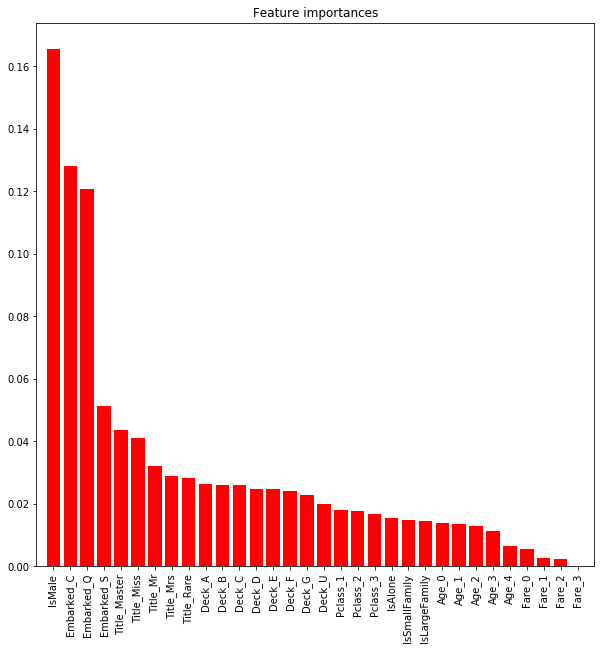

In [777]:
evalutate_random_forest(X, y)

Виждаме, че основният фактор е полът, следван от мястото на качване и титлите. Интересно е, че палубата доста допринася за оценката.

Скорът на тест сета обаче се смъкна доста. Нека се опитаме да намерим по-добри параметри.

In [780]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [5, 10, 20],
                 'max_features': ['sqrt', 'log2'],
                 'min_samples_split': [2, 5, 10, 20]
                 }

forest = RandomForestClassifier(random_state=0, n_jobs=-1)

grid_search = GridSearchCV(forest,
                           scoring='accuracy',
                           param_grid=parameter_grid,
                           cv=5)

grid_search.fit(X, y)

pd.set_option('max_colwidth', 200)
results_df = pd.DataFrame(grid_search.cv_results_)
results_df[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,params
69,1,0.824916,"{'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 20, 'n_estimators': 5}"
57,1,0.824916,"{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 5}"
36,1,0.824916,"{'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 5}"
24,1,0.824916,"{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 5}"
26,5,0.823793,"{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 20}"


Намерихме {'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 20, 'n_estimators': 5}.
Тези хипер-параметри ми донесоха **0.79904** score на Leaderboard-а.

След още малко играчка и хвърляне на боб, успях да намеря по-добри параметри, с които постигнах по-добър резултат.

Параметрите са {'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 20, 'n_estimators': 20} и резултата на Leaderboard-a е **0.81339**.

### Submission

In [786]:
def prepare_submission(model, test_data, filename='submission.csv'):
    predictions = model.predict(test_data)
    frame = pd.DataFrame({
        'PassengerId': pd.read_csv('data/titanic/test.csv').PassengerId,
        'Survived': predictions
    })
    frame = frame.set_index('PassengerId')
    frame.to_csv('data/titanic/{}'.format(filename))
    print(frame.head())

In [787]:
transformed_test_data = transform_data(test_data)
params = {'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 20, 'n_estimators': 20}

model = RandomForestClassifier(random_state=0, **params)
model.fit(X, y)

prepare_submission(model, transformed_test_data, 'titanic_submission.csv')

             Survived
PassengerId          
892                 0
893                 1
894                 0
895                 0
896                 1


# Conclusion

Успяхме да вдигнем малко резултата без да правим драматични промени по фийчъриите. Забелязах, че най-голям скок в score-a имах когато биннах годините и цената на билетите. Също така палубата играе по-голяма роля, отколкото очаквах.

Ключовото в случая ми се струва, че беше напипването на правилните хипер-параметри на модела. Най-вероятно моят модел не генерализира достатъчно добре, затова не ми даде най-добрите параметри от Grid Search-a.